# Prophet API

- Prophet follows the sklearn model API.

- First up, we create an instance of the Prophet class and then call its fit and predict methods.

- The input to Prophet is always a dataframe with two columns - ds and y.

- The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

- The y column must be numeric, and represents the measurement we wish to forecast.

In [68]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from statsmodels.tsa.stattools import adfuller, acf
import plotly.offline as py
py.init_notebook_mode()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('C:\\Users\\frank\\OneDrive\\Desktop\\Kaggle\\data\\AirPassengers.csv')
df.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [4]:
df.rename(columns = {'#Passengers':'AirPassengers'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          144 non-null    object
 1   AirPassengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


- We can see that the dataset contains a Month and AirPassengers column.

- Their data types are object and int64 respectively.

- The Prophet library expects as input a dataframe with one column containing the time information, and another column containing the metric that we wish to forecast.

- The important thing to note is that, the Month column must be of the datetime type. But, we can see that it is of object data type. Now, because the Month column is not of the datetime type. So, we’ll need to convert it into datetime type.

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df.dtypes

Month            datetime64[ns]
AirPassengers             int64
dtype: object

In [6]:
df = df.rename(columns={'Month': 'ds',
                        'AirPassengers': 'y'})

df.head()

ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121

# Visualize the data

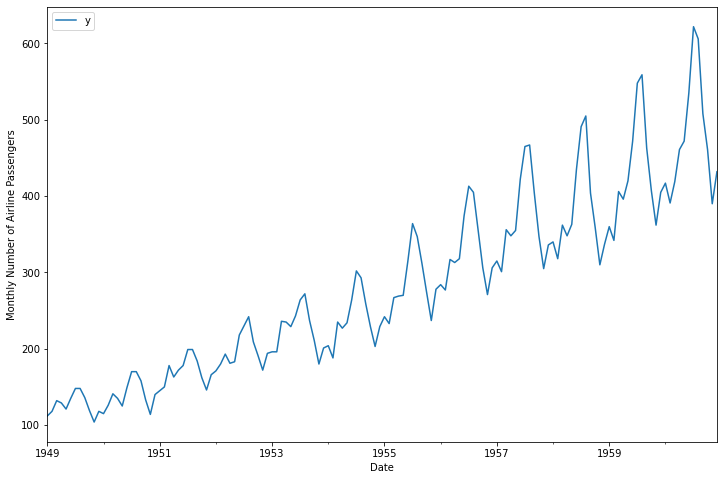

In [7]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

# Time Series Forecasting with Prophet

- Now, we will describe how to use the Prophet library to predict future values of our time series data.

- The developers of Prophet have made it more intuitive for analysts and developers alike to work with time series data.

- To begin, we must instantiate a new Prophet object. Prophet enables us to specify a number of arguments. For example, we can specify the desired range of our uncertainty interval by setting the interval_width parameter.

In [8]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

- Now that our Prophet model has been initialized, we can call its fit method with our DataFrame as input.

In [9]:
my_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- In order to obtain forecasts of our time series, we must provide Prophet with a new DataFrame containing a ds column that holds the dates for which we want predictions.

- Conveniently, we do not have to concern ourselves with manually creating this DataFrame, as Prophet provides the make_future_dataframe helper function.

In [10]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.head()

ds
0 1949-01-01
1 1949-02-01
2 1949-03-01
3 1949-04-01
4 1949-05-01

In [11]:
df.shape

(144, 2)

In [12]:
future_dates.shape

(180, 1)

- In the code snippet above, we instructed Prophet to generate 36 datestamps in the future.
- When working with Prophet, it is important to consider the frequency of our time series.
- Because we are working with monthly data, we clearly specified the desired frequency of the timestamps (in this case, MS is the start of the month).
- Therefore, the make_future_dataframe generated 36 monthly timestamps for us.
- In other words, we are looking to predict future values of our time series 3 years into the future.


- The DataFrame of future dates is then used as input to the predict method of our fitted model.

In [13]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 1949-01-01   84.378677   41.116589  132.033570
1 1949-02-01   77.786826   33.688073  120.069282
2 1949-03-01  109.994541   63.157670  154.252838
3 1949-04-01  107.446903   62.123489  149.959529
4 1949-05-01  110.934953   69.731133  153.844184

Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting. These are:

- ds: the datestamp of the forecasted value
- yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- yhat_lower: the lower bound of our forecasts
- yhat_upper: the upper bound of our forecasts

- A variation in values from the output presented is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts.
- MCMC is a stochastic process, so values will be slightly different each time.


- Prophet also provides a convenient function to quickly plot the results of our forecasts as follows:

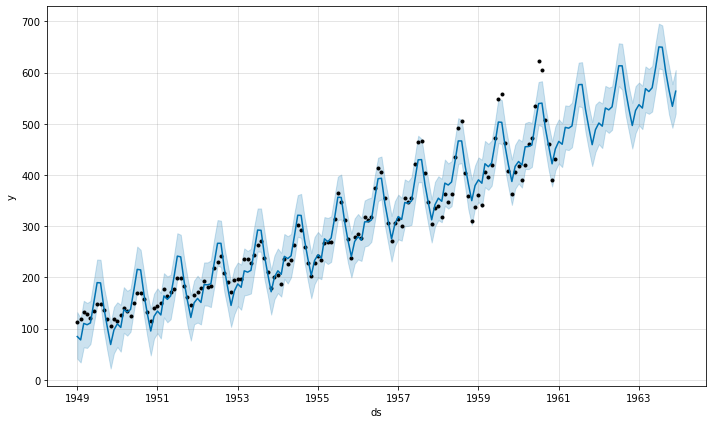

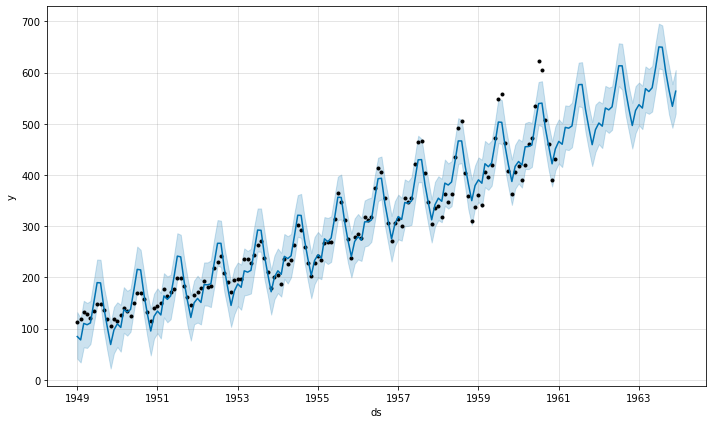

In [14]:
my_model.plot(forecast, uncertainty=True)

- Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

- One other particularly strong feature of Prophet is its ability to return the components of our forecasts.

- This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

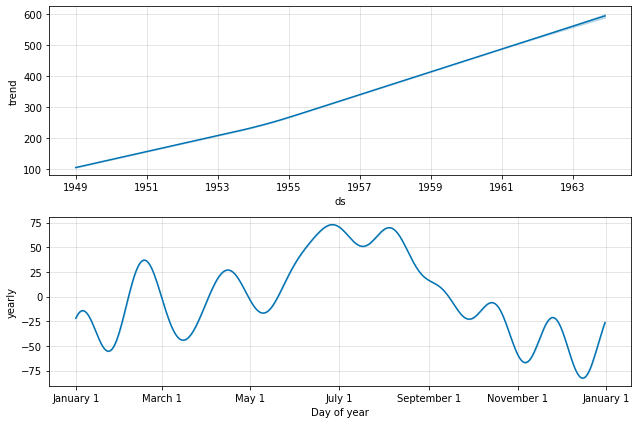

In [15]:
fig1 = my_model.plot_components(forecast)

# Adding ChangePoints to Prophet

- Changepoints are the datetime points where the time series have abrupt changes in the trajectory.

- By default, Prophet adds 25 changepoints to the initial 80% of the data-set.

- Let’s plot the vertical lines where the potential changepoints occurred.

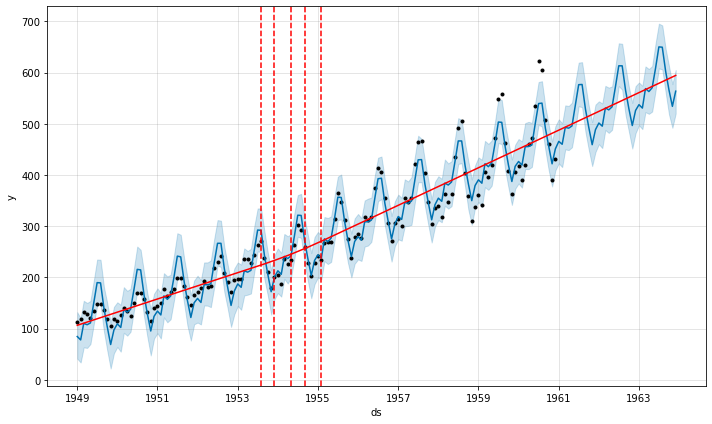

In [16]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [17]:
my_model.changepoints

5     1949-06-01
9     1949-10-01
14    1950-03-01
18    1950-07-01
23    1950-12-01
27    1951-04-01
32    1951-09-01
36    1952-01-01
41    1952-06-01
46    1952-11-01
50    1953-03-01
55    1953-08-01
59    1953-12-01
64    1954-05-01
68    1954-09-01
73    1955-02-01
78    1955-07-01
82    1955-11-01
87    1956-04-01
91    1956-08-01
96    1957-01-01
100   1957-05-01
105   1957-10-01
109   1958-02-01
114   1958-07-01
Name: ds, dtype: datetime64[ns]

- We can change the inferred changepoint range by setting the changepoint_range

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


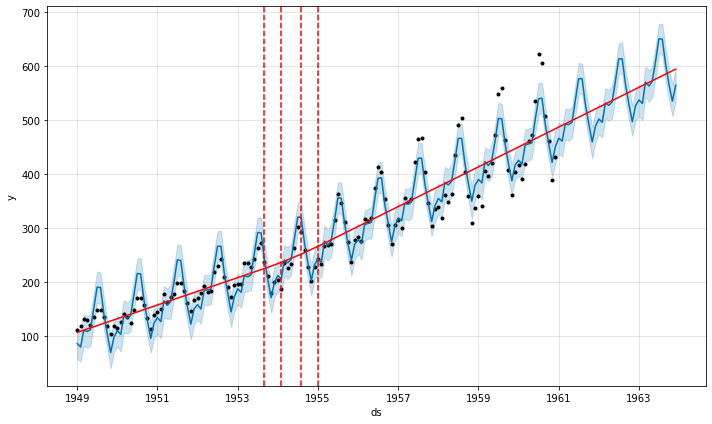

In [18]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

- The number of changepoints can be set by using the n_changepoints parameter when initializing prophet.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


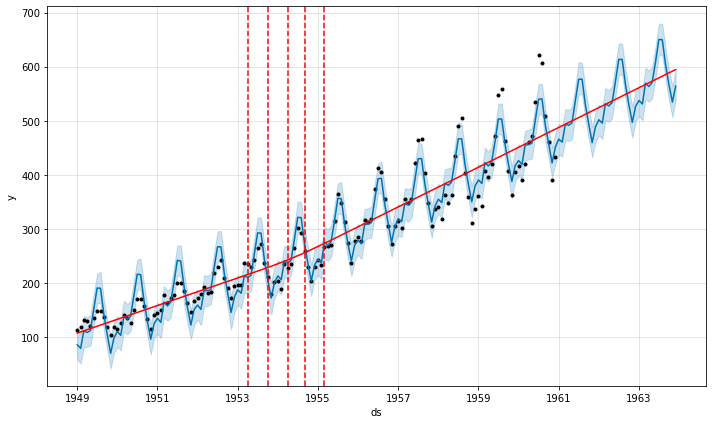

In [19]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

# Adjust Trend

- Prophet allows us to adjust the trend in case there is an overfit or underfit.

- changepoint_prior_scale helps adjust the strength of the trend.

- Default value for changepoint_prior_scale is 0.05.

- Decrease the value to make the trend less flexible.

- Increase the value of changepoint_prior_scale to make the trend more flexible.

- Increasing the changepoint_prior_scale to 0.08 to make the trend flexible.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


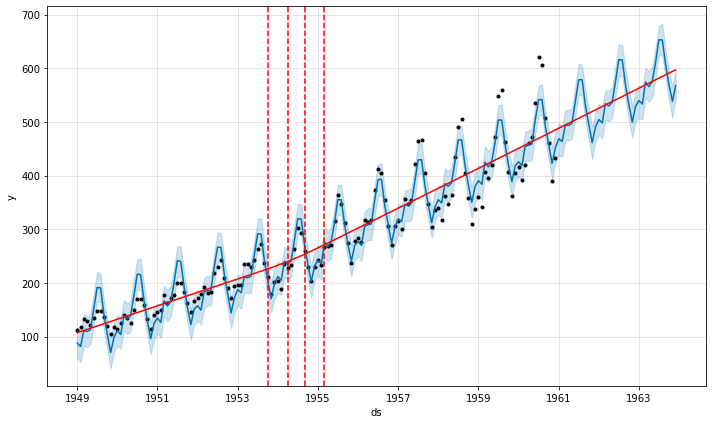

In [20]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

- Decreasing the changepoint_prior_scale to 0.001 to make the trend less flexible.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


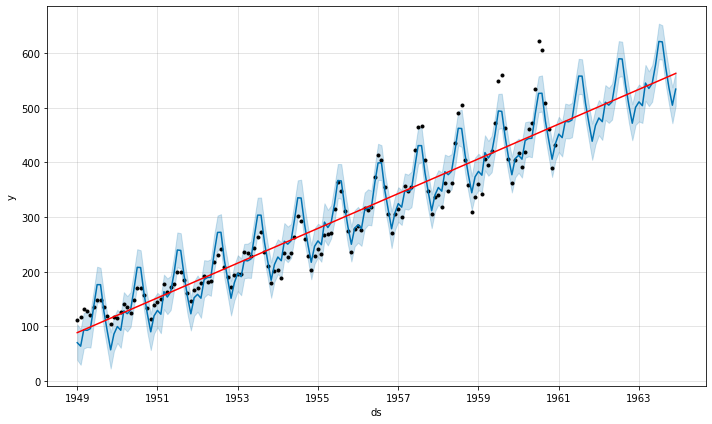

In [21]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

# Prophet on ARIMA data

In [22]:
df_a = pd.read_csv('C:\\Users\\frank\\OneDrive\\Desktop\\Kaggle\\data\\ARIMA.txt')

df_a.head()

date     value
0  1991-07-01  3.526591
1  1991-08-01  3.180891
2  1991-09-01  3.252221
3  1991-10-01  3.611003
4  1991-11-01  3.565869

In [23]:
df_a['date'] = pd.to_datetime(df_a['date'])
df_a.columns = ['ds', 'y']

In [29]:
split = int(0.7*df_a.shape[0])
train = df_a.loc[ : split , :]
test = df_a.loc[split :, :]

In [48]:
my_model = Prophet(interval_width=0.95, yearly_seasonality=True, seasonality_mode = 'multiplicative', changepoint_prior_scale=0.1)
my_model.fit(train)
future_dates = my_model.make_future_dataframe(periods = len(test), freq='MS')

- Choose seasonality_mode as 'multiplicative' as it outperforms the 'addictive' model
- Need decompose the data first and find out the which one is the better model

In [49]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds      yhat  yhat_lower  yhat_upper
0 1991-07-01  3.257586    2.540625    3.988699
1 1991-08-01  3.312313    2.630478    4.111267
2 1991-09-01  3.451852    2.745065    4.186281
3 1991-10-01  3.539153    2.829604    4.287896
4 1991-11-01  3.695437    2.905167    4.424909

In [50]:
fc = forecast.loc[split:, ['ds', 'yhat']]

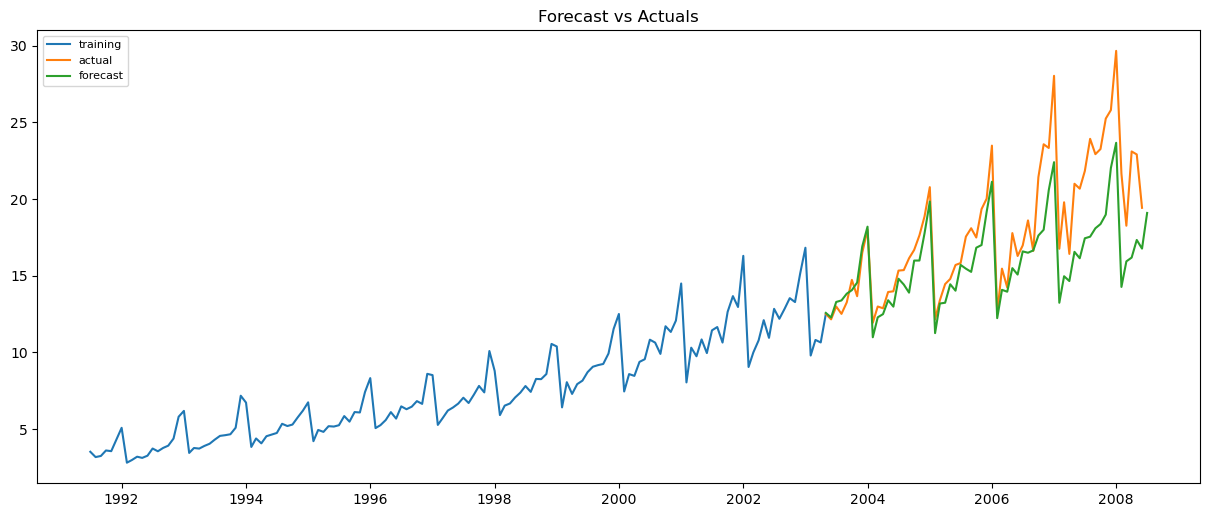

In [51]:
plt.figure(figsize=(15,6), dpi=100)
plt.plot(train['ds'], train['y'], label='training')
plt.plot(test['ds'], test['y'], label='actual')
plt.plot(fc['ds'], fc['yhat'], label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



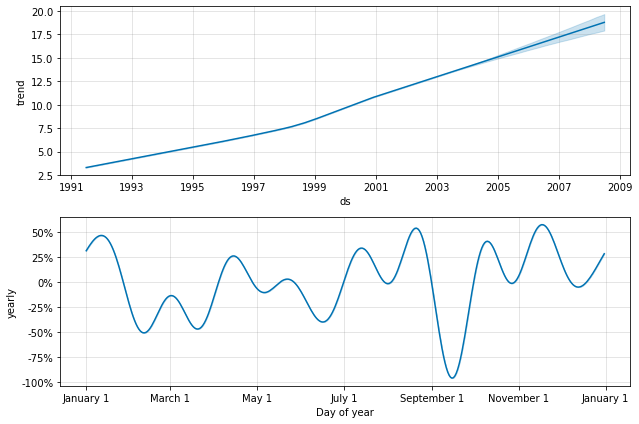

In [52]:
fig1 = my_model.plot_components(forecast)

In [53]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [69]:
forecast_accuracy(fc['yhat'].values[:62], test['y'].values)

C:\Users\frank\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



{'mape': 0.10908622006296165,
 'me': -2.107285993828217,
 'mae': 2.2189830031401807,
 'mpe': -0.10088991721149096,
 'rmse': 3.0229605185713955,
 'acf1': 0.6651453699176442,
 'corr': 0.8968564375316529,
 'minmax': 0.10889766562015224}

- The results seemed better than that using ARIMA